In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import datetime
%matplotlib inline

In [2]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 3
kernel_size2 = 3
#kernel_size3 = 5
n_grid = 100
strides1 = 1
strides2 = 2
lr=5e-04
batch_size=20

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs2"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_poisson = "D:\\CNN_poisson_files\\poisson\\bc2"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data])

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 16, n_grid, n_grid))

In [12]:
image = 1-image/100

In [13]:
# Laplace/Poisson field
field_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin_poisson + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        field_df = pd.concat([field_df, data], axis=0)

In [14]:
field_np = field_df.iloc[:, :].values

In [15]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(field_np)
imputed_field = imr.transform(field_np)

In [16]:
field = imputed_field.reshape((133, 16, n_grid, n_grid))

In [17]:
field_nor = (field-np.min(field))/(np.max(field)-np.min(field))

In [18]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [19]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [20]:
geometry = geometry.reshape((133, 16, 1))

In [21]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, field_nor, test_size=0.3, random_state=1)

In [22]:
np.max(field_nor)

1.0

In [23]:
np.max(field)

2.9023895095188

In [24]:
np.min(field)

-5.26392124908248

In [25]:
np.max(image)

1.0

In [26]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3], 1))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3], 1))

In [27]:
tf.keras.backend.set_image_data_format('channels_last')

In [28]:
model = tf.keras.models.load_model('D:\\TrainedModels\\20221030\\Poisson_bc2_100kernel_2by2MaxPooling_2CNNlayer_testSize0.3.h5')

In [30]:
#with mirrored_strategy.scope():
test_results = model.evaluate(x_train)

47/47 [==============================] - 1s 9ms/step - loss: 6.4941e-06 - rmse: 0.0000e+00


In [31]:
#with mirrored_strategy.scope():
decoded_train = model.predict(x_train)

47/47 [==============================] - 3s 14ms/step


In [32]:
#with mirrored_strategy.scope():
decoded_test = model.predict(x_test)

20/20 [==============================] - 0s 11ms/step


In [33]:
error_train_abs = np.abs(decoded_train - y_train)

In [34]:
error_test_abs = np.abs(decoded_test - y_test)

In [35]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0005947902515351787


In [36]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.006634378937110951


In [37]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
#print(l2_error_train_list)

In [38]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
#print(l2_error_test_list)

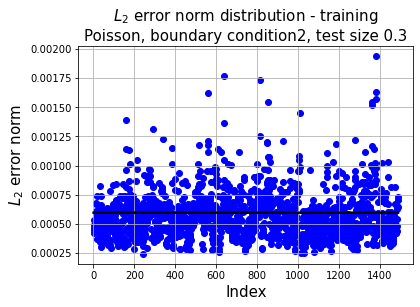

In [39]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm distribution - training\nPoisson, boundary condition2, test size 0.3',
          fontsize=15)
plt.grid()
save_variance_name = "20221030L2ErrorDistribution_Poisson_bc2(training).jpg"
plt.savefig(save_variance_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

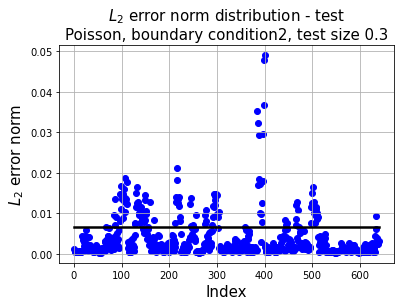

In [40]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm distribution - test\nPoisson, boundary condition2, test size 0.3',
          fontsize=15)
plt.grid()
save_variance_name = "20221030L2ErrorDistribution_Poisson_bc2(test).jpg"
plt.savefig(save_variance_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [41]:
os.chdir("D:\\CNN_poisson_files\\images\\20221030\\testSize0.3")

0.9998094905292183
0.00019050947078169678
0.9967931238309984
0.0032068761690016157


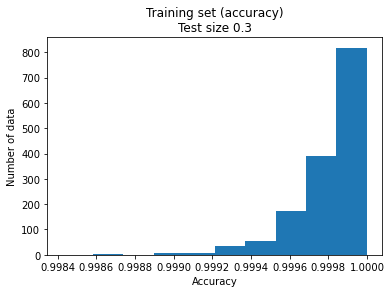

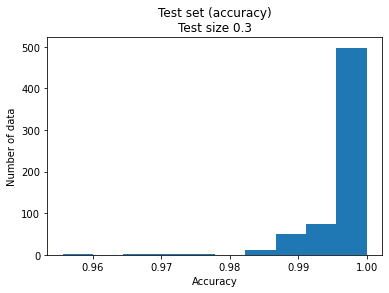

In [59]:
yTrainSum = np.zeros((y_train.shape[0],1))
dTrainSum = np.zeros((decoded_train.shape[0], 1))
MAPE_train_list = np.zeros((y_train.shape[0], 1))
for i in range(0, y_train.shape[0]):
    yTrainSum[i,:] = np.sum(y_train[i])
    dTrainSum[i,:] = np.sum(decoded_train[i])
    MAPE_train_list[i,:] = np.abs((dTrainSum[i,:]-yTrainSum[i,:])/yTrainSum[i,:])
    
MAPE_train = 1-np.sum(MAPE_train_list)/x_train.shape[0]
print(MAPE_train)
acc_train = 1-MAPE_train
print(acc_train)
acc_train_list = 1 - MAPE_train_list

yTestSum = np.zeros((y_test.shape[0],1))
dTestSum = np.zeros((decoded_test.shape[0], 1))
MAPE_test_list = np.zeros((y_test.shape[0], 1))
for i in range(0, y_test.shape[0]):
    yTestSum[i,:] = np.sum(y_test[i])
    dTestSum[i,:] = np.sum(decoded_test[i])
    MAPE_test_list[i,:] = np.abs((dTestSum[i,:]-yTestSum[i,:])/yTestSum[i,:])
    
MAPE_test = 1-np.sum(MAPE_test_list)/x_test.shape[0]
print(MAPE_test)
acc_test = 1-MAPE_test
print(acc_test)
acc_test_list = 1 - MAPE_test_list

plt.hist(acc_train_list)
plt.title('Training set (accuracy)\nTest size 0.3')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
#plt.grid()
plt.show()

plt.hist(acc_test_list)
plt.title('Test set (accuracy)\nTest size 0.3')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
plt.show()

In [52]:
y_train.shape

(1488, 100, 100, 1)

In [53]:
decoded_test.shape

(640, 100, 100, 1)

In [55]:
MAPE_train = (np.sum(np.abs(np.sum(y_train)-np.sum(decoded_train)/(np.sum(y_train)))))/(y_train.shape[0]/16)*100
acc_train = 1-MAPE_train

In [57]:
MAPE_test = (np.sum(np.abs(np.sum(y_test)-np.sum(decoded_test))) / np.abs(np.sum(y_test)))/(y_test.shape[0]/16)*100
acc_test = 1-MAPE_test

In [56]:
print(MAPE_train)
print(acc_train)

10445013.82598526
-10445012.82598526


In [58]:
print(MAPE_test)
print(acc_test)

0.004342056508532257
0.9956579434914677


In [47]:
MAPE_train_list = []
acc_train_list = []
for i in range(0, len(aa_train)):
    MAPE_train_data = (np.sum(np.abs(y_train[i]-decoded_train[i])) / np.sum(np.abs(y_train[i])))/(y_train.shape[0]/16)*100
    MAPE_train_list.append(MAPE_train_data)
    acc_train_data = 1 - MAPE_train_data
    acc_train_list.append(acc_train_data)
print(MAPE_train_list)
print(acc_train_list)

[0.0003808807746751127, 0.0003833465833165343, 0.0003383970467492044, 0.000382397210734393, 0.00037335110121196476, 0.0003764684409601358, 0.0003662125774446568, 0.00038526301385729525, 0.00037491553802581403, 0.00038258720363146405, 0.00042149006599019536, 0.0005680628407418374, 0.00046307796309233445, 0.00048046289396067894, 0.0005243576567109684, 0.0005854265073741738, 0.0004899598746013863, 0.00033819479930768064, 0.0002964446639543465, 0.00038061058700768284, 0.0004043649224907763, 0.0003954294299062646, 0.0004063063994739478, 0.0004620726566741225, 0.0003727073596160412, 0.00039632564791490895, 0.00037661485421076185, 0.00045056558219106835, 0.0005018370889349239, 0.0005249754928939426, 0.0005133177484121, 0.0007040951572327722, 0.0003165457343280399, 0.00025120597208773946, 0.0002355714676276156, 0.0005275487678493459, 0.00029677680595653285, 0.0006139792733868052, 0.000572673570453651, 0.00045011192679181484, 0.0004250114044453281, 0.0002715693768410422, 0.00034917579084254154,

In [48]:
MAPE_test_list = []
acc_test_list = []
for i in range(0, len(aa_test)):
    MAPE_test_data = (np.sum(np.abs(y_test[i]-decoded_test[i])) / np.sum(np.abs(y_test[i])))/(y_test.shape[0]/16)*100
    MAPE_test_list.append(MAPE_test_data)
    acc_test_data = 1 - MAPE_test_data
    acc_test_list.append(acc_test_data)
print(MAPE_test_list)
print(acc_test_list)

[0.0024326611299583783, 0.0011285492295869605, 0.0007507157725995309, 0.0007309613820353902, 0.0013393752878058669, 0.0012414269422274496, 0.0010279725643445523, 0.000662357145239758, 0.0009585188349649288, 0.0014636437313348158, 0.0010767442217214278, 0.0010252790107575746, 0.0014068516624156356, 0.0010450826100508895, 0.0009605531990260853, 0.0014778269365592295, 0.00926624030362182, 0.009053649203550266, 0.007004292007523379, 0.001219541427209382, 0.003941351683620494, 0.006159683813112643, 0.00945017564657353, 0.008141156712919092, 0.011903492150614547, 0.008391571496033142, 0.0029014678563788767, 0.004987434045808025, 0.0013262292679821033, 0.008626117897676562, 0.00469324239537575, 0.008891007907834881, 0.0043693658242057, 0.0031968136239829237, 0.002478065825489997, 0.00174464562312451, 0.0019863287327484846, 0.0023537312625965963, 0.0008552059485317109, 0.0017629372486147805, 0.0010003808520241179, 0.0015501337642099587, 0.001324514212232606, 0.0026033409278321934, 0.0017987968

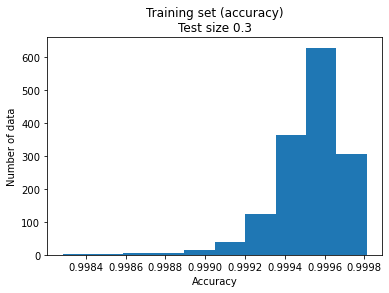

In [49]:
plt.hist(acc_train_list)
plt.title('Training set (accuracy)\nTest size 0.3')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
#plt.grid()
save_acc_name = "20221030Accuracy_Poisson_bc2(training).jpg"
plt.savefig(save_acc_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

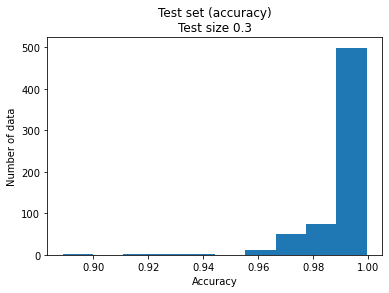

In [50]:
plt.hist(acc_test_list)
plt.title('Test set (accuracy)\nTest size 0.3')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
save_acc_name = "20221030Accuracy_Poisson_bc2(test).jpg"
plt.savefig(save_acc_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

NameError: name 'xmesh' is not defined

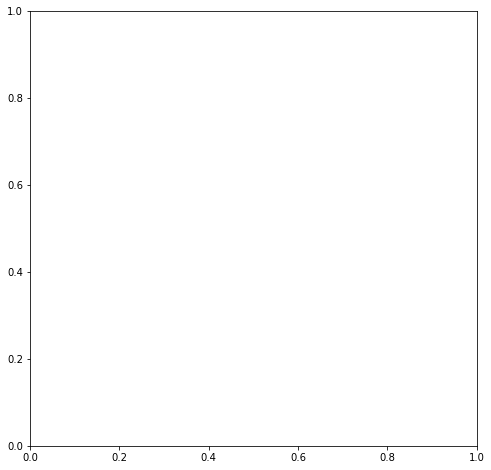

In [51]:
error_test_abs2_rotate = error_test_abs[-1].reshape(n_grid,n_grid).T

fig5 = plt.figure(figsize = (8, 8))
ax5 = fig5.add_subplot(111)
mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[-1])[3:-2],
                                                                   aa_test[-1], l2_error_test_list[-1]), fontsize=16)
ax5.set_xlabel('$y$', fontsize=15)
ax5.set_ylabel('$z$', fontsize=15)

cax = plt.axes([0.12, 0.005, 0.78, 0.05])
cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
cbar.set_label('Error', fontsize=15)

save_fig_name = "20221030PredictionError_Poisson_bc2(test)"+str(np.array2string(geo_test[-1])[3:-2])+str(aa_test[-1])+".jpg"
plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
error_test_abs2_rotate = error_test_abs[-2].reshape(n_grid,n_grid).T

fig5 = plt.figure(figsize = (8, 8))
ax5 = fig5.add_subplot(111)
mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[-2])[3:-2],
                                                                   aa_test[-2], l2_error_test_list[-2]), fontsize=16)
ax5.set_xlabel('$y$', fontsize=15)
ax5.set_ylabel('$z$', fontsize=15)

cax = plt.axes([0.12, 0.005, 0.78, 0.05])
cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
cbar.set_label('Error', fontsize=15)

save_fig_name = "20221030PredictionError_Poisson_bc2(test)"+str(np.array2string(geo_test[-2])[3:-2])+str(aa_test[-2])+".jpg"
plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
c=-1
plt.figure(figsize=(16, 8))
y_test0_rotate = y_test[c].reshape(n_grid,n_grid).T
decoded_rotate = decoded_test[c].reshape(n_grid,n_grid).T

xrange = np.linspace(-2, 2, n_grid)
yrange = np.linspace(-2, 2, n_grid)
xmesh, ymesh = np.meshgrid(xrange, yrange)

ax = plt.subplot(1, 2, 1)
a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=np.min(y_test0_rotate),
                  vmax=np.max(y_test0_rotate), levels=128, cmap='seismic')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Original test image', fontsize=15)

# Display reconstruction
ax = plt.subplot(1, 2, 2)
a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=np.min(y_test0_rotate),
                  vmax=np.max(y_test0_rotate), levels=128, cmap='seismic')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Reconstructed image', fontsize=15)
cax = plt.axes([0.12, 0.005, 0.78, 0.05])
cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
cbar.set_label('Poisson field', fontsize=15)
#cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
save_fig_name = "20221030Prediction_Poisson_bc2(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
c=-2
plt.figure(figsize=(16, 8))
y_test0_rotate = y_test[c].reshape(n_grid,n_grid).T
decoded_rotate = decoded_test[c].reshape(n_grid,n_grid).T

xrange = np.linspace(-2, 2, n_grid)
yrange = np.linspace(-2, 2, n_grid)
xmesh, ymesh = np.meshgrid(xrange, yrange)

ax = plt.subplot(1, 2, 1)
a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=np.min(y_test0_rotate),
                  vmax=np.max(y_test0_rotate), levels=128, cmap='seismic')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Original test image', fontsize=15)

# Display reconstruction
ax = plt.subplot(1, 2, 2)
a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=np.min(y_test0_rotate),
                  vmax=np.max(y_test0_rotate), levels=128, cmap='seismic')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Reconstructed image', fontsize=15)
cax = plt.axes([0.12, 0.005, 0.78, 0.05])
cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
cbar.set_label('Poisson field', fontsize=15)
#cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
save_fig_name = "20221030Prediction_Poisson_bc2(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
c=-16
plt.figure(figsize=(16, 8))
y_test0_rotate = y_test[c].reshape(n_grid,n_grid).T
decoded_rotate = decoded_test[c].reshape(n_grid,n_grid).T

xrange = np.linspace(-2, 2, n_grid)
yrange = np.linspace(-2, 2, n_grid)
xmesh, ymesh = np.meshgrid(xrange, yrange)

ax = plt.subplot(1, 2, 1)
a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=np.min(y_test0_rotate),
                  vmax=np.max(y_test0_rotate), levels=128, cmap='seismic')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Original test image', fontsize=15)

# Display reconstruction
ax = plt.subplot(1, 2, 2)
a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=np.min(y_test0_rotate),
                  vmax=np.max(y_test0_rotate), levels=128, cmap='seismic')
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Reconstructed image', fontsize=15)
cax = plt.axes([0.12, 0.005, 0.78, 0.05])
cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
cbar.set_label('Poisson field', fontsize=15)
#cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
save_fig_name = "20221030Prediction_Poisson_bc2(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
error_test_abs2_rotate = error_test_abs[-15].reshape(n_grid,n_grid).T

fig5 = plt.figure(figsize = (8, 8))
ax5 = fig5.add_subplot(111)
mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[-15])[3:-2],
                                                                   aa_test[-15], l2_error_test_list[-15]), fontsize=16)
ax5.set_xlabel('$y$', fontsize=15)
ax5.set_ylabel('$z$', fontsize=15)

cax = plt.axes([0.12, 0.005, 0.78, 0.05])
cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
cbar.set_label('Error', fontsize=15)

save_fig_name = "20221030PredictionError_Poisson_bc2(test)"+str(np.array2string(geo_test[-15])[3:-2])+str(aa_test[-15])+".jpg"
plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
for c in range(96,112):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid).T
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid).T

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=np.min(y_test0_rotate),
                      vmax = np.max(y_test0_rotate),levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=np.min(y_test0_rotate),
                      vmax = np.max(y_test0_rotate),levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Poisson field', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    save_fig_name = "20221030Prediction_Poisson_bc2(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [ ]:
for c in range(96,112):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid).T

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$x$', fontsize=15)
    ax5.set_ylabel('$y$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221030PredictionError_Poisson_bc2(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()